# Moments, Sorting, Approximating and Matching Contours

- contour area
- iterate/sort through contours
- different styles to draw a contour (box, contour, hullvex, ...)
- finding matching contours

---
### Imports and Helper-functions

In [86]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [87]:
def imshow(img, title=None, size=10, axis=False, color_space="BGR"):
    aspect_ratio = img.shape[0] / img.shape[1]
    plt.figure(figsize=(size * aspect_ratio, size))
    if color_space.lower() == "bgr":
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_space.lower() == "rgb":
        rgb_img = img
    else:
        rgb_img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(rgb_img)
    if type(title) == str:
        plt.title(title)
    if axis == False:
        plt.axis('off')
    plt.show()

In [88]:
def get_random_img_path(search_path='../../res/img', skip=["flickr"]):
    """
    This function searches for common image files in all subdirectories
    and return a random image path of them.
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.ico']
    image_paths = []

    # Walk through all subdirectories
    for root, dirs, files in os.walk(search_path):
        for file_name in files:
            # Check if the file is an image
            if any(file_name.lower().endswith(ext) for ext in image_extensions):
                # Get the full file path
                full_path = os.path.join(root, file_name).replace("\\", "/")
                if not any(i in full_path for i in skip):
                    image_paths.append(full_path)

    return random.choice(image_paths)

# get an image
IMG_PATH = get_random_img_path(skip=["flickr", "weather", "gem"])
IMG_PATH   

'../../res/img/Lions/430fd1bf11e8576c.jpg'

In [89]:
IMG_PATH = '../../res/img/chinese_art/Dataset/Ai_Xuan/Ai_Xuan_13.jpg'

---
### Loading data

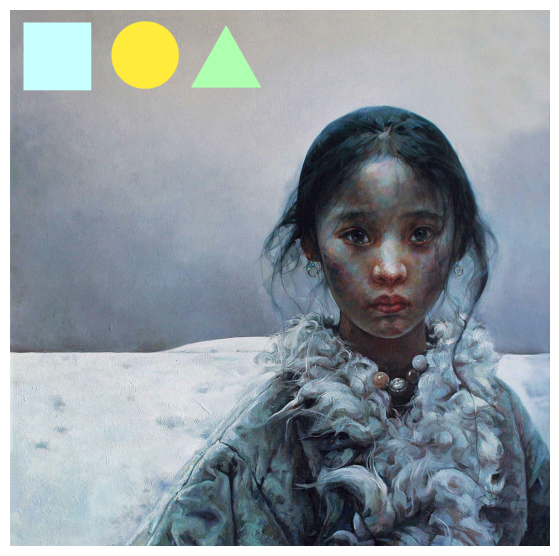

In [90]:
img = cv2.imread(IMG_PATH)
cv2.rectangle(img, (50, 50), (300, 300), (255, 255, 200), -1)
cv2.circle(img, (500, 170), 125, (60, 235, 255), -1)
points = np.array([
    [800, 170-110],
    [800+130, 170+120],
    [800-130, 170+120]
], dtype=np.int32)
cv2.drawContours(img, [points], 0, (177, 255, 175), -1)
imshow(img, size=7)

apply and adjust binarization

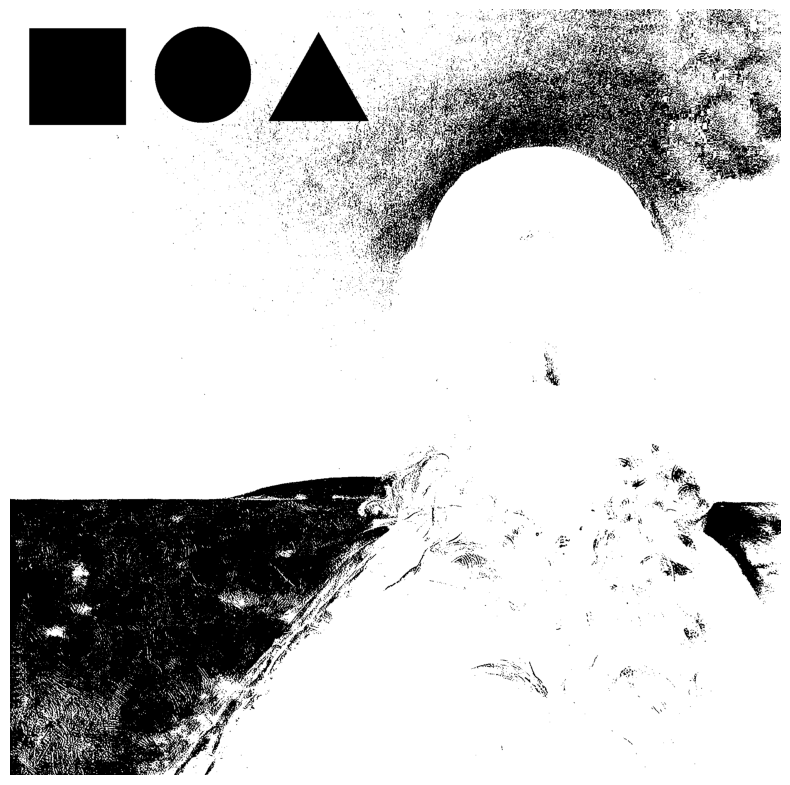

In [91]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
t, t_img = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)
imshow(t_img)

---
### Contour Area

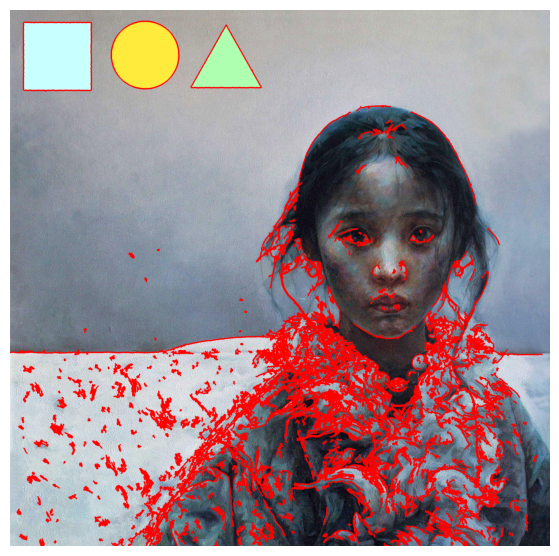

In [92]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.blur(gray, ksize=(3, 3))
t_img = cv2.Canny(blur, 50, 200)

contours, hierarchy = cv2.findContours(t_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

copy_img = img.copy()
cv2.drawContours(copy_img, contours, -1, (0, 0, 255), 3)
imshow(copy_img, size=7)

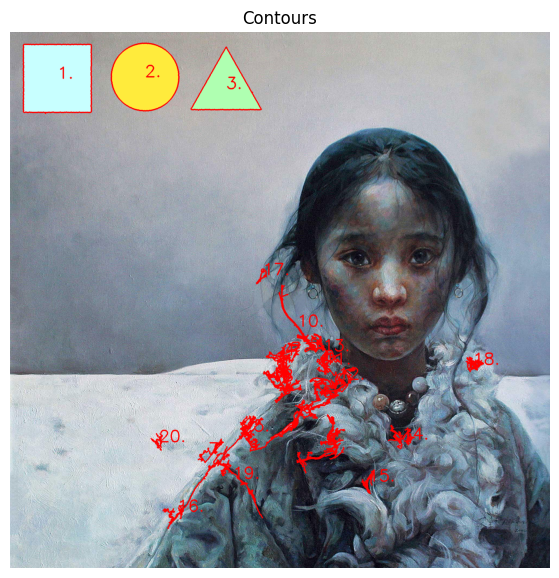

In [93]:
def get_contour_areas(contours):
    areas = []
    for cur_con in contours:
        areas += [cv2.contourArea(cur_con)]
    return areas

sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
areas = get_contour_areas(sorted_contours[:5])

copy_img = img.copy()

for idx, cur_contour in enumerate(sorted_contours[:20], 1):
    M = cv2.moments(cur_contour)
    x = int(M['m10']/(M['m00']+1e-10000))
    y = int(M['m01']/(M['m00']+0.000001))
    cv2.putText(copy_img, f"{idx}.", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
    cv2.drawContours(copy_img, [cur_contour], -1, (0, 0, 255), 3)

imshow(copy_img, "Contours", size=7)

---
### Sorting by Location

In [94]:
def filter_contours(contours, area_size_limit=300):
    filtered_contours = []
    for cur_contour in contours:
        if cur_contour is not None and cv2.contourArea(cur_contour) > area_size_limit:
            filtered_contours += [cur_contour]
    return filtered_contours

def x_coordinate_contour(contours):
    M = cv2.moments(contours)
    return int(M['m10']/(M['m01']+0.00001))

def label_contour_center(img, contour):
    M = cv2.moments(contour)
    x = int(M['m10']/(M['m00']+0.000001))
    y = int(M['m01']/(M['m00']+0.000001))
    cv2.circle(img, (x, y), 10, (0, 0, 255), -1)
    return img

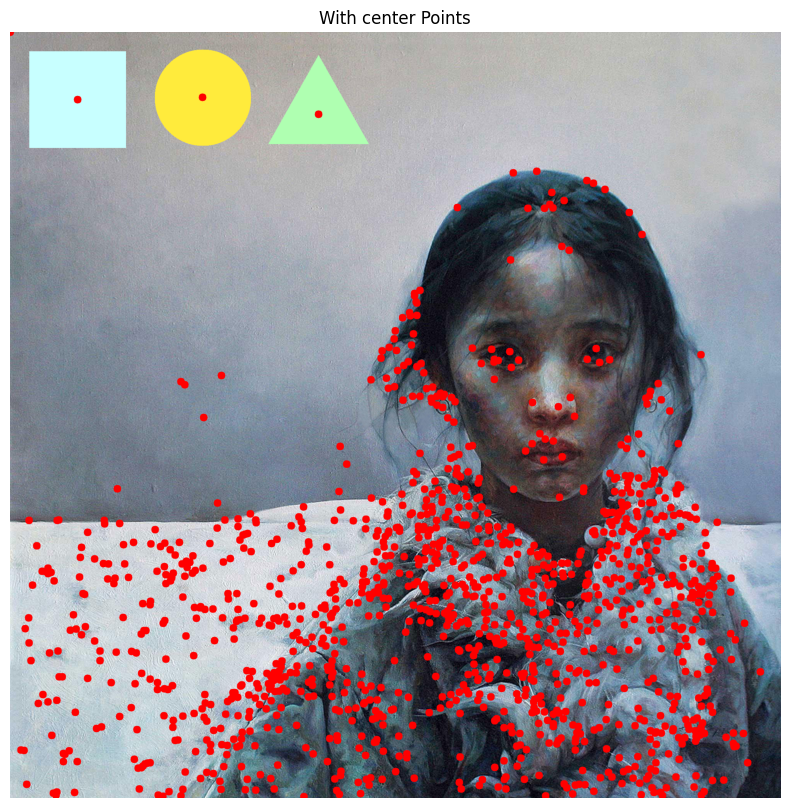

In [95]:
copy_img = img.copy()
for idx, cur_con in enumerate(contours, 1):
    label_contour_center(copy_img, cur_con)
imshow(copy_img, "With center Points")

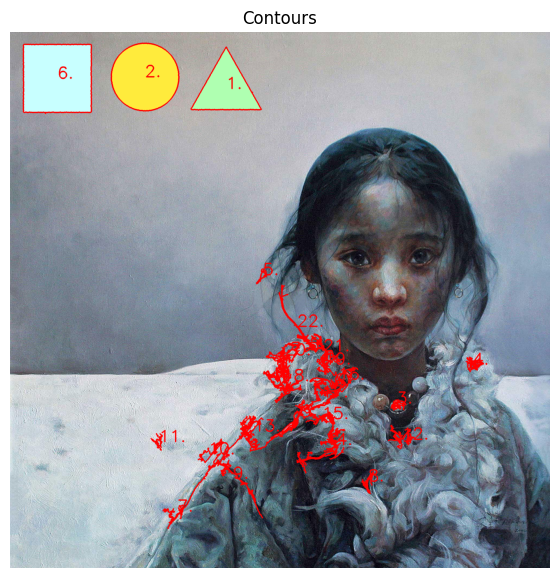

In [96]:
copy_img = img.copy()

filtered = filter_contours(contours)
filtered_contours_right_to_left = sorted(filtered, key=x_coordinate_contour, reverse=True)

for idx, cur_con in enumerate(filtered_contours_right_to_left, 1):
    M = cv2.moments(cur_con)
    x = int(M['m10']/(M['m00']+1e-10000))
    y = int(M['m01']/(M['m00']+0.000001))
    cv2.putText(copy_img, f"{idx}.", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
    cv2.drawContours(copy_img, [cur_con], -1, (0, 0, 255), 3)
    x, y, w, h = cv2.boundingRect(cur_con)

imshow(copy_img, "Contours", size=7)

---
### Approximating Contours

It approximates a contour shape to another shape with less number of vertices depending upon the precision we specify.


```python
cv2.approxPolyDP(contour, Approximation Accuracy, Closed)
```

- **contour** – is the individual contour we wish to approximate
- **Approximation Accuracy** – Important parameter is determining the accuracy of the approximation. Small values give precise-  approximations, large values give more generic approximation. A good rule of thumb is less than 5% of the contour perimeter
- **Closed** – a Boolean value that states whether the approximate contour should be open or closed 

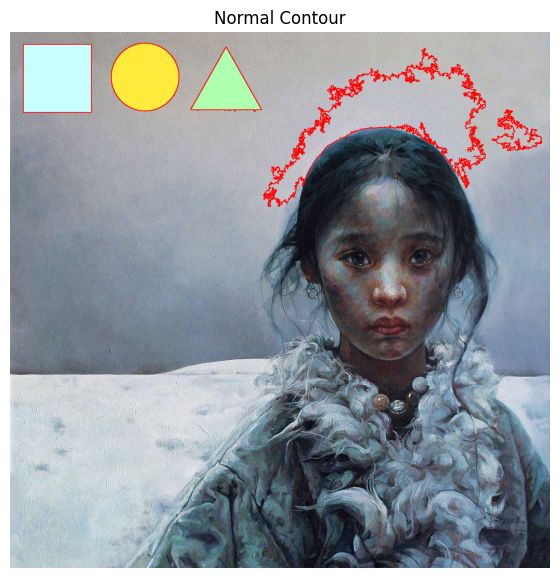

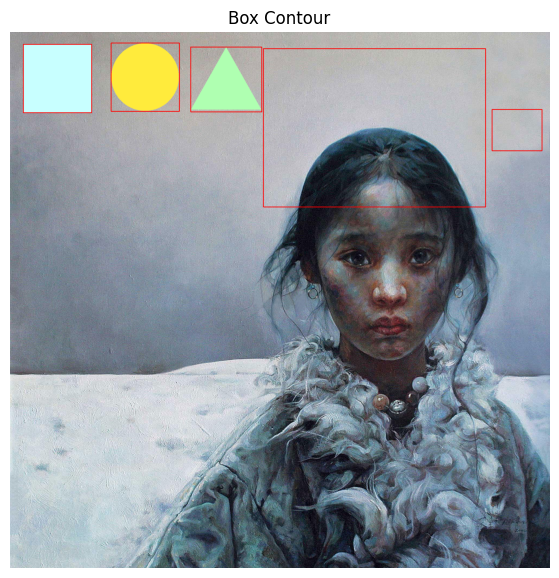

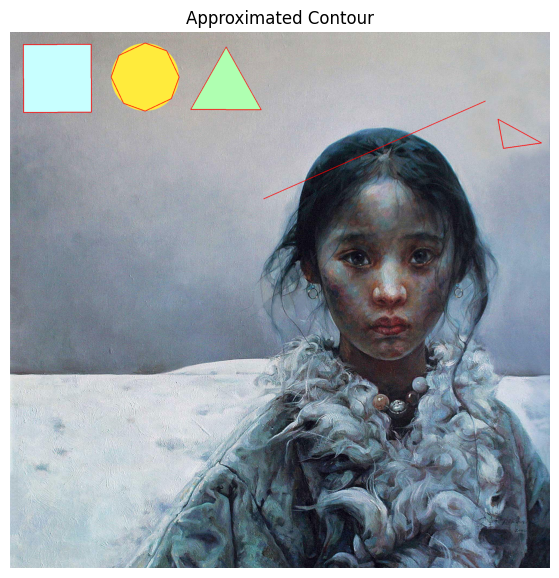

In [97]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
t, t_img = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)

contours, hierarchy = cv2.findContours(t_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
filtered = filter_contours(contours, area_size_limit=10000)

# remove biggest contour
filtered = sorted(filtered, key=cv2.contourArea, reverse=True)[1:]

# Normal contour
copy_img = img.copy()
for cur_contour in filtered:
    x, y, w, h = cv2.boundingRect(cur_contour)
    cv2.drawContours(copy_img, [cur_contour], 0, (0, 0, 255), 2)
imshow(copy_img, "Normal Contour", size=7)

# Box Contour
copy_img = img.copy()
for cur_contour in filtered:
    x, y, w, h = cv2.boundingRect(cur_contour)
    cv2.rectangle(copy_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
imshow(copy_img, "Box Contour", size=7)

# approximated contour
copy_img = img.copy()
for cur_contour in filtered:
    accuracy = 0.03*cv2.arcLength(cur_contour, True)
    approx = cv2.approxPolyDP(cur_contour, accuracy, True)
    cv2.drawContours(copy_img, [approx], 0, (0, 0, 255), 2)
imshow(copy_img, "Approximated Contour", size=7)

---
### Convex Hull

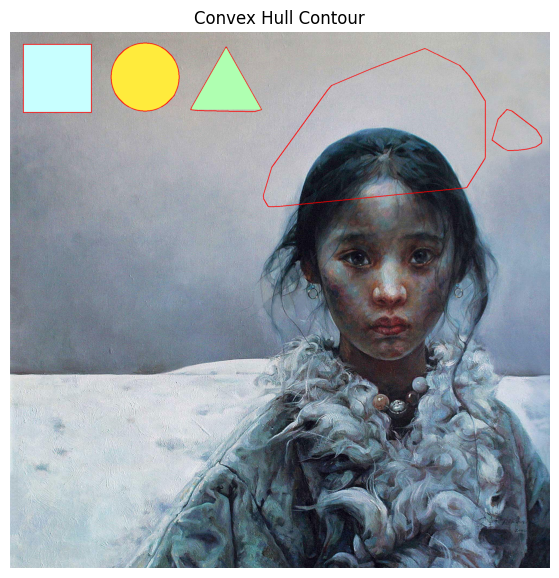

In [98]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
t, t_img = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)

contours, hierarchy = cv2.findContours(t_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
filtered = filter_contours(contours, area_size_limit=10000)

# remove biggest contour
filtered = sorted(filtered, key=cv2.contourArea, reverse=True)[1:]

# Convex Hull contour
copy_img = img.copy()
for cur_contour in filtered:
    hull = cv2.convexHull(cur_contour)
    cv2.drawContours(copy_img, [hull], 0, (0, 0, 255), 2)
imshow(copy_img, "Convex Hull Contour", size=7)

---
### Matching Contours

```python
cv2.matchShapes(contour template, contour, method, method parameter)
```

**Output** – match value (lower values means a closer match)

- Contour Template – This is our reference contour that we’re trying to find in the new image
- Contour – The individual contour we are checking against
- Method – Type of contour matching (1, 2, 3)
- Method Parameter – leave alone as 0.0 (not fully utilized in python OpenCV)

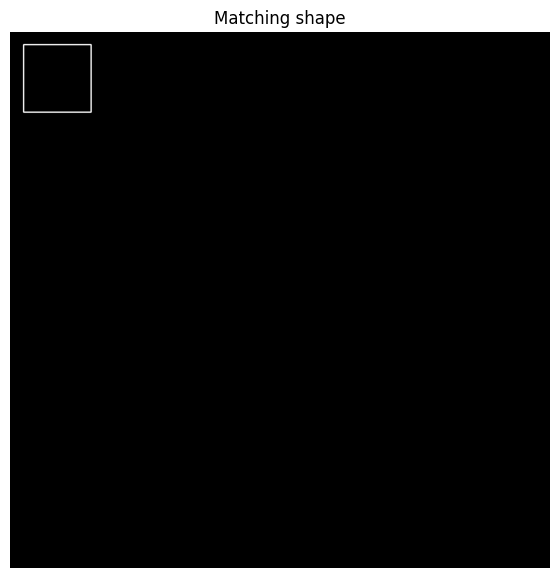

In [121]:
img_2 = img.copy()
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
cv2.rectangle(img_2, (0, 0), (img_2.shape[1], img_2.shape[0]), 0, -1)
cv2.rectangle(img_2, (50, 50), (300, 300), 255, 4)
imshow(img_2, "Matching shape", size=7)

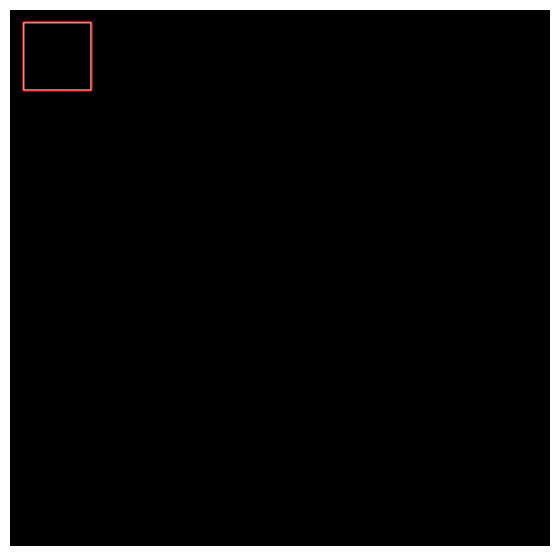

In [122]:
# get contour
t, t_img_2 = cv2.threshold(img_2, 190, 255, cv2.THRESH_BINARY_INV)

contours, hierarchy = cv2.findContours(t_img_2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
template_contours = filter_contours(contours, area_size_limit=10000)

# remove biggest contour
template_contours = sorted(template_contours, key=cv2.contourArea, reverse=True)[1:]

copy_img = img_2
copy_img = cv2.cvtColor(copy_img, cv2.COLOR_GRAY2BGR)
template_contour = template_contours[0]
cv2.drawContours(copy_img, [template_contour], -1, (0, 0, 255), 3)
imshow(copy_img, size=7)

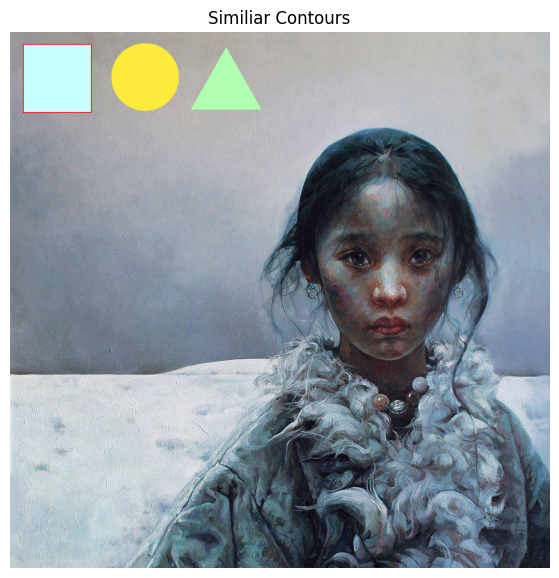

In [130]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
t, t_img_1 = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)

contours, hierarchy = cv2.findContours(t_img_1, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = filter_contours(contours, area_size_limit=10000)

# remove biggest contour
contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]

# find matching contour
similiar_contours = []
for cur_contour in contours:
    match_to_template = cv2.matchShapes(template_contour, cur_contour, 3, 0.0)
    
    if match_to_template < 0.01:
        similiar_contours += [cur_contour]

copy_img = img.copy()
cv2.drawContours(copy_img, similiar_contours, -1, (0, 0, 255), 2)
imshow(copy_img, "Similiar Contours", size=7)

---